## 1. Setup & Imports

In [1]:
import json
import re
from pathlib import Path
from typing import List, Dict, Any

import cv2
import numpy as np
from ultralytics import YOLO
from tqdm.auto import tqdm

## 2. Configuration

In [7]:
# Project paths
PROJECT_ROOT = Path(r"e:\container-id-research")
WEIGHTS_PATH = PROJECT_ROOT / "weights" / "detection" / "best.pt"
RAW_DATA_DIR = PROJECT_ROOT / "data" / "raw"
OUTPUT_JSON = PROJECT_ROOT / "data" / "interim" / "predictions_full.json"

# Inference parameters
CONFIDENCE_THRESHOLD = 0.8
IMAGE_EXTENSIONS = {".jpg", ".jpeg", ".png"}

print(f"Model weights: {WEIGHTS_PATH}")
print(f"Raw data directory: {RAW_DATA_DIR}")
print(f"Output file: {OUTPUT_JSON}")
print(f"Confidence threshold: {CONFIDENCE_THRESHOLD}")

Model weights: e:\container-id-research\weights\detection\best.pt
Raw data directory: e:\container-id-research\data\raw
Output file: e:\container-id-research\data\interim\predictions_full.json
Confidence threshold: 0.8


## 3. Utility Functions

In [3]:
def extract_image_id(filename: str) -> int:
    """
    Extract numeric image ID from filename.

    Examples:
        - "0016135.jpg" → 16135
        - "container_001.jpg" → None (returns None if no numeric pattern)

    Args:
        filename: Image filename (with or without extension)

    Returns:
        Extracted integer ID or None if not found
    """
    # Remove extension
    name_without_ext = Path(filename).stem

    # Try to extract leading numeric sequence
    match = re.match(r"^(\d+)", name_without_ext)
    if match:
        return int(match.group(1))

    # If no numeric prefix, try to find any number
    numbers = re.findall(r"\d+", name_without_ext)
    if numbers:
        return int(numbers[0])

    return None


def yolo_to_coco_bbox(
    yolo_bbox: List[float], img_width: int, img_height: int
) -> List[float]:
    """
    Convert YOLO bbox format to COCO format.

    YOLO format: [x_center, y_center, width, height] (normalized 0-1)
    COCO format: [x_top_left, y_top_left, width, height] (absolute pixels)

    Args:
        yolo_bbox: YOLO bounding box [x_center, y_center, width, height]
        img_width: Image width in pixels
        img_height: Image height in pixels

    Returns:
        COCO format bounding box [x, y, w, h]
    """
    x_center, y_center, width, height = yolo_bbox

    # Convert from normalized to absolute coordinates
    x_center_abs = x_center * img_width
    y_center_abs = y_center * img_height
    width_abs = width * img_width
    height_abs = height * img_height

    # Convert center format to top-left format
    x_top_left = x_center_abs - (width_abs / 2)
    y_top_left = y_center_abs - (height_abs / 2)

    return [x_top_left, y_top_left, width_abs, height_abs]


# Test the extraction function
test_filenames = [
    "0016135.jpg",
    "0000065.jpg",
    "container_back_door_1.png",
    "FVNHCM251000157810_Phi-Nang-Cont_20251029_193150_3.jpg",
]
for fname in test_filenames:
    image_id = extract_image_id(fname)
    print(f"{fname} → image_id: {image_id}")

0016135.jpg → image_id: 16135
0000065.jpg → image_id: 65
container_back_door_1.png → image_id: 1
FVNHCM251000157810_Phi-Nang-Cont_20251029_193150_3.jpg → image_id: 251000157810


## 4. Load Model

In [4]:
# Verify model exists
if not WEIGHTS_PATH.exists():
    raise FileNotFoundError(f"Model weights not found at {WEIGHTS_PATH}")

print("Loading YOLOv11 model...")
model = YOLO(str(WEIGHTS_PATH))
print(f"✓ Model loaded successfully: {model.model_name}")
print(f"  Classes: {model.names}")

Loading YOLOv11 model...
✓ Model loaded successfully: e:\container-id-research\weights\detection\best.pt
  Classes: {0: 'container_door'}


## 5. Collect Image Files

In [5]:
# Collect all valid image files
image_files = []
for ext in IMAGE_EXTENSIONS:
    image_files.extend(RAW_DATA_DIR.glob(f"*{ext}"))

# Sort for reproducibility
image_files = sorted(image_files)

print(f"Found {len(image_files)} images in {RAW_DATA_DIR}")
print(f"Sample images: {[f.name for f in image_files[:5]]}")

Found 831 images in e:\container-id-research\data\raw
Sample images: ['0000065.jpg', '0000088.jpg', '0000089.jpg', '0000155.jpg', '0000160.jpg']


## 6. Run Inference on All Images

In [8]:
predictions: List[Dict[str, Any]] = []
fallback_id_counter = 0

print(f"Running inference on {len(image_files)} images...")
print(f"Confidence threshold: {CONFIDENCE_THRESHOLD}\n")

for img_path in tqdm(image_files, desc="Processing images"):
    # Read image to get dimensions
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"Warning: Could not read {img_path.name}, skipping...")
        continue

    img_height, img_width = img.shape[:2]

    # Extract image_id from filename
    image_id = extract_image_id(img_path.name)
    if image_id is None:
        # Fallback: use incremental counter
        image_id = fallback_id_counter
        fallback_id_counter += 1

    # Run inference
    results = model.predict(
        source=str(img_path), conf=CONFIDENCE_THRESHOLD, verbose=False
    )

    # Process detections
    for result in results:
        boxes = result.boxes

        for i in range(len(boxes)):
            # Get YOLO format bbox (normalized xywh)
            xywhn = (
                boxes.xywhn[i].cpu().numpy()
            )  # [x_center, y_center, width, height] normalized
            confidence = float(boxes.conf[i].cpu().numpy())
            class_id = int(boxes.cls[i].cpu().numpy())

            # Convert to COCO format
            coco_bbox = yolo_to_coco_bbox(xywhn.tolist(), img_width, img_height)

            # Create prediction entry
            prediction = {
                "image_id": image_id,
                "file_name": img_path.name,
                "category_id": 1,  # Container door class
                "bbox": [round(coord, 2) for coord in coco_bbox],  # Round to 2 decimals
                "score": round(confidence, 4),
            }

            predictions.append(prediction)

print(f"\n✓ Inference complete!")
print(f"  Total predictions: {len(predictions)}")
print(f"  Images processed: {len(image_files)}")
print(f"  Average detections per image: {len(predictions) / len(image_files):.2f}")

Running inference on 831 images...
Confidence threshold: 0.8



Processing images:   0%|          | 0/831 [00:00<?, ?it/s]


✓ Inference complete!
  Total predictions: 829
  Images processed: 831
  Average detections per image: 1.00


## 7. Save Predictions to JSON

In [9]:
# Save to JSON file
with open(OUTPUT_JSON, "w", encoding="utf-8") as f:
    json.dump(predictions, f, indent=2, ensure_ascii=False)

print(f"✓ Predictions saved to: {OUTPUT_JSON}")
print(f"  File size: {OUTPUT_JSON.stat().st_size / 1024:.2f} KB")

✓ Predictions saved to: e:\container-id-research\data\interim\predictions_full.json
  File size: 154.57 KB


## 8. Verification & Statistics

In [10]:
# Show sample predictions
print("\n=== Sample Predictions ===")
for pred in predictions[:5]:
    print(json.dumps(pred, indent=2))
    print("-" * 50)


=== Sample Predictions ===
{
  "image_id": 65,
  "file_name": "0000065.jpg",
  "category_id": 1,
  "bbox": [
    49.0,
    0.0,
    1294.02,
    1521.06
  ],
  "score": 0.9442
}
--------------------------------------------------
{
  "image_id": 88,
  "file_name": "0000088.jpg",
  "category_id": 1,
  "bbox": [
    0.0,
    372.15,
    1425.87,
    1329.98
  ],
  "score": 0.9565
}
--------------------------------------------------
{
  "image_id": 89,
  "file_name": "0000089.jpg",
  "category_id": 1,
  "bbox": [
    0.2,
    0.0,
    1439.16,
    1646.55
  ],
  "score": 0.9583
}
--------------------------------------------------
{
  "image_id": 155,
  "file_name": "0000155.jpg",
  "category_id": 1,
  "bbox": [
    2.14,
    47.0,
    1427.88,
    1542.93
  ],
  "score": 0.9527
}
--------------------------------------------------
{
  "image_id": 160,
  "file_name": "0000160.jpg",
  "category_id": 1,
  "bbox": [
    1.6,
    2.53,
    840.38,
    1163.73
  ],
  "score": 0.9401
}
----------

In [11]:
# Statistics
scores = [p["score"] for p in predictions]
unique_images = len(set(p["image_id"] for p in predictions))

print("\n=== Prediction Statistics ===")
print(f"Total predictions: {len(predictions)}")
print(f"Unique images with detections: {unique_images}")
print(f"Images without detections: {len(image_files) - unique_images}")
print(f"\nConfidence scores:")
print(f"  Min:  {min(scores):.4f}")
print(f"  Max:  {max(scores):.4f}")
print(f"  Mean: {np.mean(scores):.4f}")
print(f"  Median: {np.median(scores):.4f}")


=== Prediction Statistics ===
Total predictions: 829
Unique images with detections: 829
Images without detections: 2

Confidence scores:
  Min:  0.8372
  Max:  0.9776
  Mean: 0.9493
  Median: 0.9516


In [12]:
# Check for images without any detections
images_with_predictions = set(p["file_name"] for p in predictions)
all_image_names = set(f.name for f in image_files)
images_without_predictions = all_image_names - images_with_predictions

if images_without_predictions:
    print(
        f"\n⚠️ Warning: {len(images_without_predictions)} images have NO detections above threshold {CONFIDENCE_THRESHOLD}"
    )
    print(f"Sample images without detections: {list(images_without_predictions)[:10]}")
else:
    print(
        f"\n✓ All images have at least one detection above threshold {CONFIDENCE_THRESHOLD}"
    )


⚠️ Warning: 2 images have NO detections above threshold 0.8
Sample images without detections: ['0029301.jpg', '0028172.jpg']


## 9. Visualize Sample Predictions

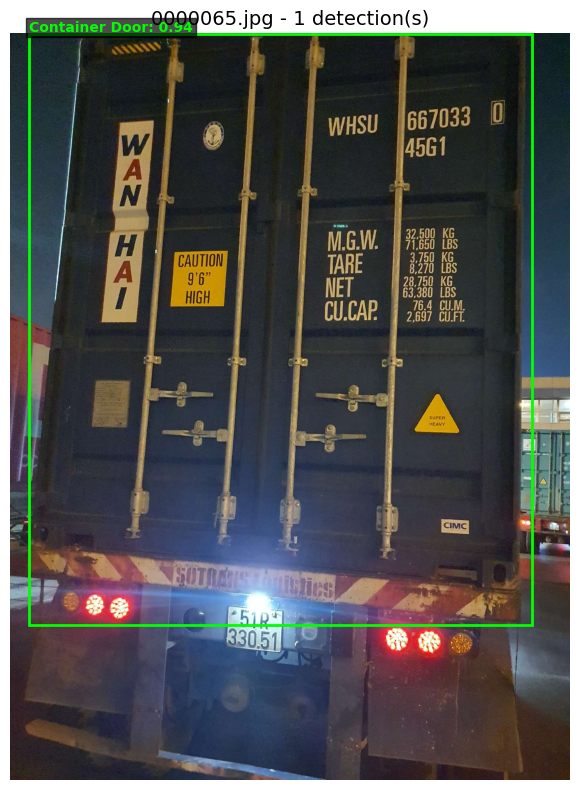

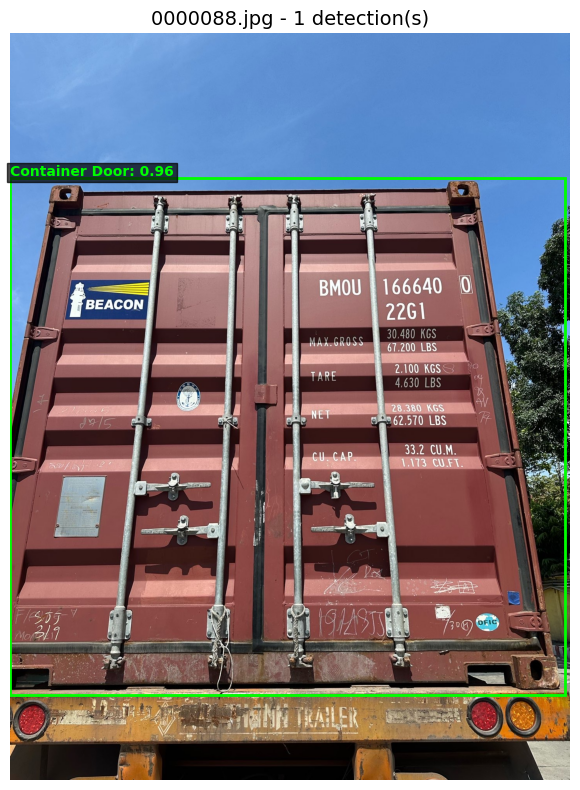

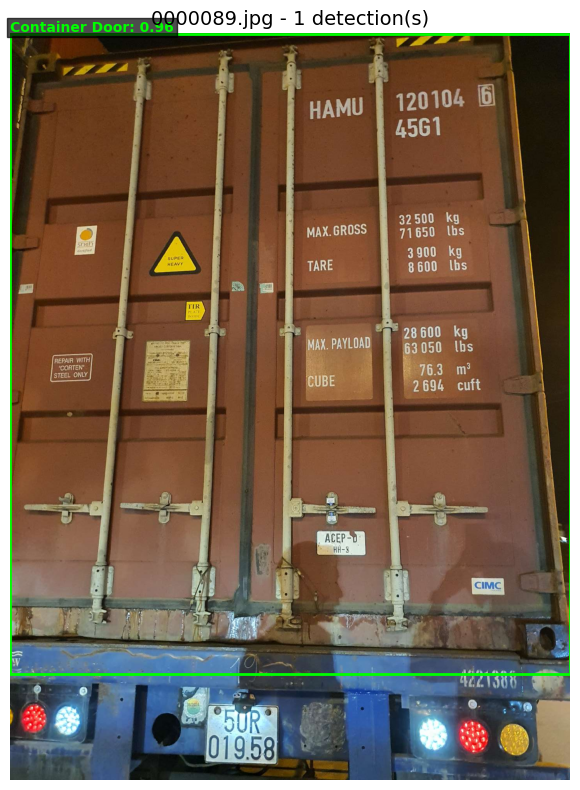

: 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def visualize_prediction(img_path: Path, predictions_list: List[Dict]) -> None:
    """
    Visualize image with predicted bounding boxes.

    Args:
        img_path: Path to the image file
        predictions_list: List of prediction dictionaries
    """
    # Read image
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Filter predictions for this image
    img_predictions = [p for p in predictions_list if p["file_name"] == img_path.name]

    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(img_rgb)

    # Draw bounding boxes
    for pred in img_predictions:
        x, y, w, h = pred["bbox"]
        score = pred["score"]

        # Create rectangle
        rect = patches.Rectangle(
            (x, y), w, h, linewidth=2, edgecolor="lime", facecolor="none"
        )
        ax.add_patch(rect)

        # Add label
        ax.text(
            x,
            y - 5,
            f"Container Door: {score:.2f}",
            color="lime",
            fontsize=10,
            fontweight="bold",
            bbox=dict(facecolor="black", alpha=0.7, pad=2),
        )

    ax.set_title(f"{img_path.name} - {len(img_predictions)} detection(s)", fontsize=14)
    ax.axis("off")
    plt.tight_layout()
    plt.show()


# Visualize first 3 images with predictions
sample_images = [f for f in image_files if f.name in images_with_predictions][:3]
for img_path in sample_images:
    visualize_prediction(img_path, predictions)

## Summary

**Task 0 Complete** ✓

**Deliverables:**
- ✓ `predictions_full.json` created with COCO format bounding boxes
- ✓ All images in `data/raw/` processed
- ✓ Only predictions with confidence > 0.5 included
- ✓ Image IDs extracted from filenames

**Next Step:**
- Proceed to **Task 1: Geometric Check & ROI Extraction**
- Use `predictions_full.json` as input for filtering and cropping